In [1]:
import pandas

In [2]:
import sklearn
from sklearn import tree
from sklearn import metrics
from sklearn import cluster
from sklearn import feature_extraction
from sklearn import model_selection

from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [3]:
from IPython.display import Image

In [4]:
import pydotplus

In [5]:
%matplotlib inline

In [6]:
# stopwords list sourced from nltk with some added terms
stopwords = ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now', 
'(', ')', '&', 'co', 'co.', 'inc.', 'inc', '1', '2', '3', '4', '5', '6', '7', '8', '9', '0', '*']

In [7]:
def prepare(df, vec, sample_size=0, test_size=0.2):
        
    # take a random sample if a sample_size was specified
    if sample_size > 0:
        df = df.sample(sample_size)

    # map 'Fail' to 0 and other (generally 'Pass') to 1
    result = df['result'].map(lambda x: 0 if x == "Fail" else 1)

    # get a subset of fields for machine learning, make sure none of the field values are 'NaN'
    sample_subset = df[["businessName", "description", "comment", "risk", "violation", "city"]]
    sample_subset = sample_subset.replace(pandas.np.nan,' ', regex=True)

    # convert the dataframe into an array of dictionarys and generate feature matrix
    _dict = sample_subset.to_dict('records')
    
    # break businessName, comment, and description into parts for feature extraction based on components
    for x in _dict:
        
        businessName = x['businessName']
        name_parts = businessName.split()
        for part in name_parts:
            if part.lower() not in stopwords:
                x['businessName='+str(part)] = True
        del x['businessName']
        
        businessName = x['comment']
        name_parts = businessName.split()
        for part in name_parts:
            if part.lower() not in stopwords:
                x['comment='+str(part)] = True
        del x['comment']
        
        businessName = x['description']
        name_parts = businessName.split()
        for part in name_parts:
            if part.lower() not in stopwords:
                x['description='+str(part)] = True
        del x['description']
        
    fm = vec.fit_transform(_dict)
    
    # split data into training and test datasets
    return train_test_split(fm, result, test_size=test_size)

In [34]:
# a second prepare method is needed to ensure the same feature set is generated for scenario where the model is built
# from only 1 city's data and used to make predictions on the other city
def prepare2(df, df2, vec, sample_size=0, test_size=0.2):
    
    # take a random sample if a sample_size was specified
    if sample_size > 0:
        df = df.sample(sample_size)
        df2 = df2.sample(sample_size)
    
    df3 = pandas.concat([df, df2])

    # map 'Fail' to 0 and other (generally 'Pass') to 1
    result = df3['result'].map(lambda x: 0 if x == "Fail" else 1)

    # get a subset of fields for machine learning, make sure none of the field values are 'NaN'
    sample_subset = df3[["businessName", "description", "comment", "risk", "violation", "city"]]
    sample_subset = sample_subset.replace(pandas.np.nan,' ', regex=True)

    # convert the dataframe into an array of dictionarys and generate feature matrix
    _dict = sample_subset.to_dict('records')
    
    # break businessName, comment, and description into parts for feature extraction based on components
    for x in _dict:
        
        businessName = x['businessName']
        name_parts = businessName.split()
        for part in name_parts:
            if part.lower() not in stopwords:
                x['businessName='+str(part)] = True
        del x['businessName']
        
        businessName = x['comment']
        name_parts = businessName.split()
        for part in name_parts:
            if part.lower() not in stopwords:
                x['comment='+str(part)] = True
        del x['comment']
        
        businessName = x['description']
        name_parts = businessName.split()
        for part in name_parts:
            if part.lower() not in stopwords:
                x['description='+str(part)] = True
        del x['description']
        
    fm = vec.fit_transform(_dict)
    
    fm_1 = fm[:len(df)-1]
    result_1 = result[:len(df)-1]
    
    fm_2 = fm[len(df):]
    result_2 = result[:len(df)]
    
    # split data into training and test datasets
    fm_train, fm_test, target_train, target_test = train_test_split(fm_1, result_1, test_size=test_size)
    
    # return results from train_test_split plus feature matrix and target values not in split
    return (fm_train, fm_test, target_train, target_test, fm_2, result_2)

In [8]:
# load boston data
BOSTON_DATA = "Food_Establishment_Inspections_(converted).csv"
boston_df = pandas.read_csv(BOSTON_DATA)

In [9]:
boston_vectorizer = DictVectorizer()

In [10]:
boston_fm_train, boston_fm_test, boston_target_train, boston_target_test = prepare(boston_df, boston_vectorizer, sample_size=100000)

In [11]:
boston_fm_train.shape

(80000, 46413)

In [12]:
boston_model = DecisionTreeClassifier()

# generate decision tree from boston training dataset
%time boston_model.fit(boston_fm_train, boston_target_train)

CPU times: user 1min 21s, sys: 408 ms, total: 1min 21s
Wall time: 1min 22s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

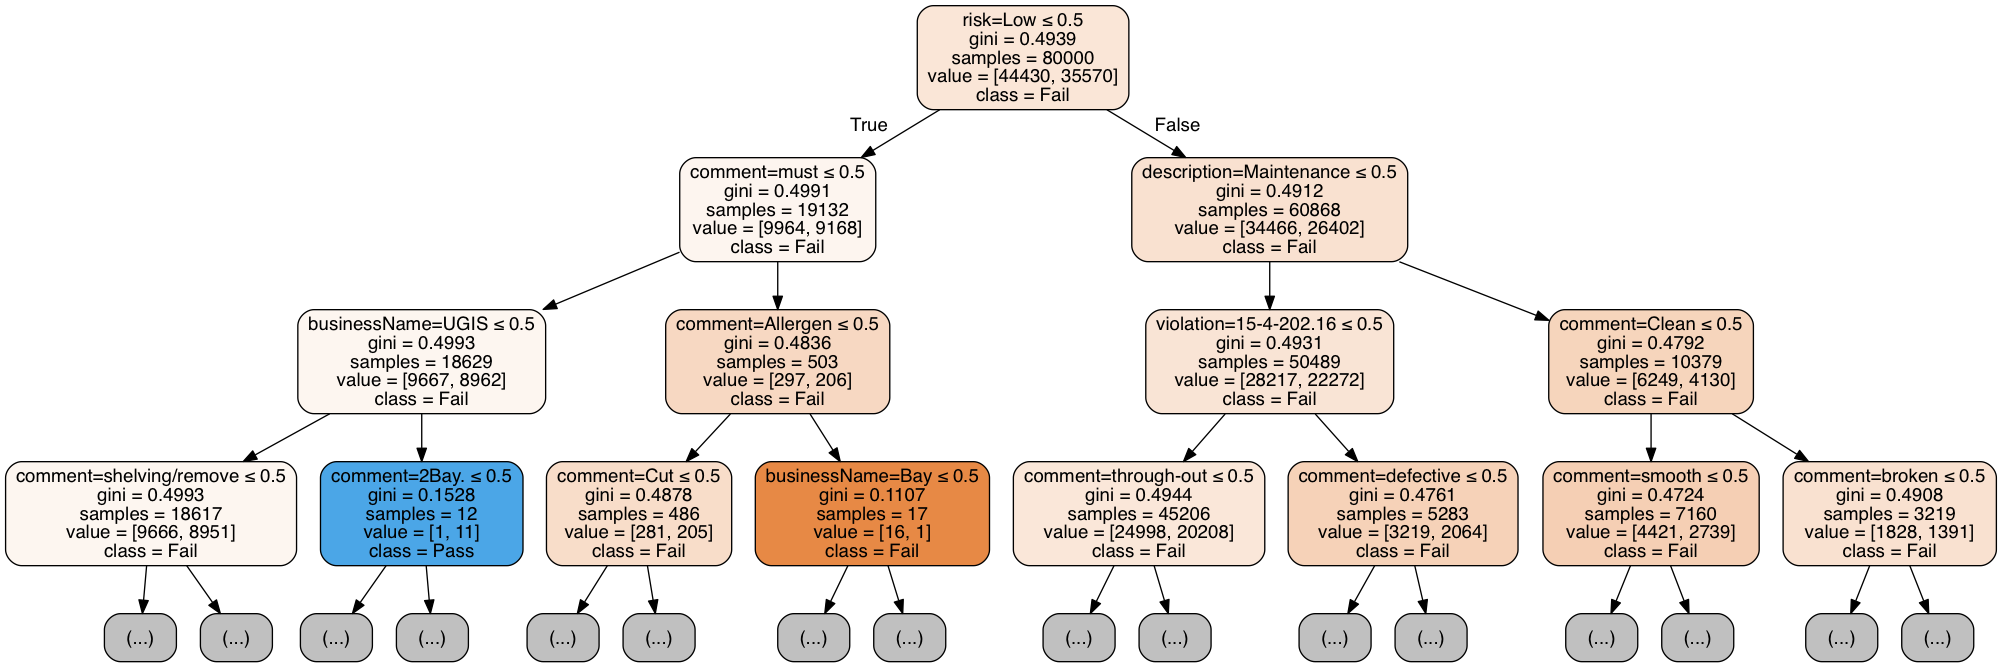

In [13]:
boston_feature_names = [x.replace('&', "and") for x in boston_vectorizer.feature_names_]
dot_data = tree.export_graphviz(boston_model, out_file=None, 
                        feature_names=boston_feature_names,
                        filled=True, rounded=True,
                        class_names=["Fail","Pass"],
                        max_depth=3,
                        special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [14]:
# generate metrics from predictions made on training data
boston_train_predicted = boston_model.predict(boston_fm_train)
print(metrics.classification_report(boston_target_train, boston_train_predicted))
print(metrics.confusion_matrix(boston_target_train, boston_train_predicted))

             precision    recall  f1-score   support

          0       0.86      1.00      0.93     44430
          1       1.00      0.80      0.89     35570

avg / total       0.92      0.91      0.91     80000

[[44396    34]
 [ 7116 28454]]


In [15]:
# generate metrics from predictions made on test data
boston_test_predicted = boston_model.predict(boston_fm_test)
print(metrics.classification_report(boston_target_test, boston_test_predicted))
print(metrics.confusion_matrix(boston_target_test, boston_test_predicted))

             precision    recall  f1-score   support

          0       0.50      0.54      0.52     11081
          1       0.36      0.32      0.34      8919

avg / total       0.44      0.45      0.44     20000

[[6039 5042]
 [6021 2898]]


In [16]:
CHICAGO_DATA = "Food_Inspections_(converted).csv"

# load chicago data
chicago_df = pandas.read_csv(CHICAGO_DATA)

# convert violation values to string
chicago_df['violation'] = chicago_df['violation'].astype('str')

In [17]:
chicago_vectorizer = DictVectorizer()

In [18]:
chicago_fm_train, chicago_fm_test, chicago_target_train, chicago_target_test = prepare(chicago_df, chicago_vectorizer, sample_size=100000)

In [19]:
chicago_fm_train.shape

(80000, 75689)

In [20]:
chicago_model = DecisionTreeClassifier()

# generate decision tree from chicago training dataset
%time chicago_model.fit(chicago_fm_train, chicago_target_train)

CPU times: user 1min 39s, sys: 459 ms, total: 1min 39s
Wall time: 1min 40s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

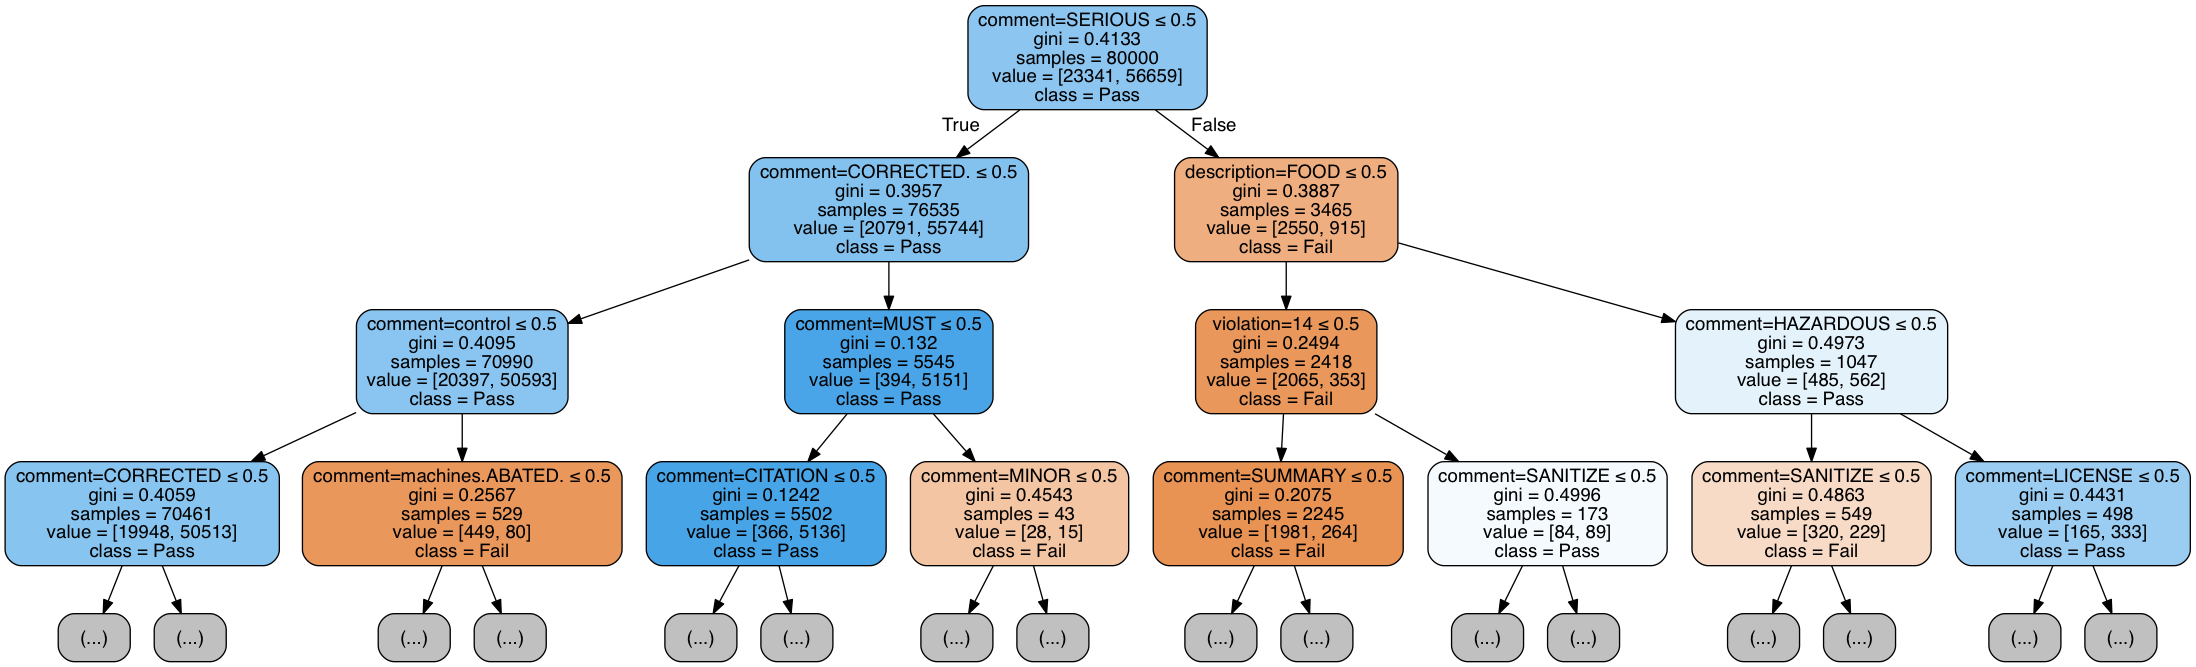

In [21]:
chicago_feature_names = [x.replace('&', "and") for x in chicago_vectorizer.feature_names_]
dot_data = tree.export_graphviz(chicago_model, out_file=None, 
                        feature_names=chicago_feature_names,
                        class_names=["Fail","Pass"],
                        max_depth=3,
                        filled=True, rounded=True,  
                        special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [22]:
# generate metrics from predictions made on training data
chicago_train_predicted = chicago_model.predict(chicago_fm_train)
print(metrics.classification_report(chicago_target_train, chicago_train_predicted))
print(metrics.confusion_matrix(chicago_target_train, chicago_train_predicted))

             precision    recall  f1-score   support

          0       0.97      1.00      0.99     23341
          1       1.00      0.99      0.99     56659

avg / total       0.99      0.99      0.99     80000

[[23331    10]
 [  667 55992]]


In [23]:
# generate metrics from predictions made on test data
chicago_test_predicted = chicago_model.predict(chicago_fm_test)
print(metrics.classification_report(chicago_target_test, chicago_test_predicted))
print(metrics.confusion_matrix(chicago_target_test, chicago_test_predicted))

             precision    recall  f1-score   support

          0       0.51      0.43      0.47      5866
          1       0.78      0.83      0.80     14134

avg / total       0.70      0.71      0.71     20000

[[ 2545  3321]
 [ 2423 11711]]


In [24]:
combined_df = pandas.concat([boston_df, chicago_df])

In [25]:
combined_vectorizer = DictVectorizer()

In [26]:
combined_fm_train, combined_fm_test, combined_target_train, combined_target_test = prepare(combined_df, combined_vectorizer, sample_size=200000)

In [27]:
combined_fm_train.shape

(160000, 117206)

In [28]:
combined_model = DecisionTreeClassifier()

# generate decision tree from chicago training dataset
%time combined_model.fit(combined_fm_train, combined_target_train)

CPU times: user 4min 44s, sys: 1.22 s, total: 4min 45s
Wall time: 4min 47s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

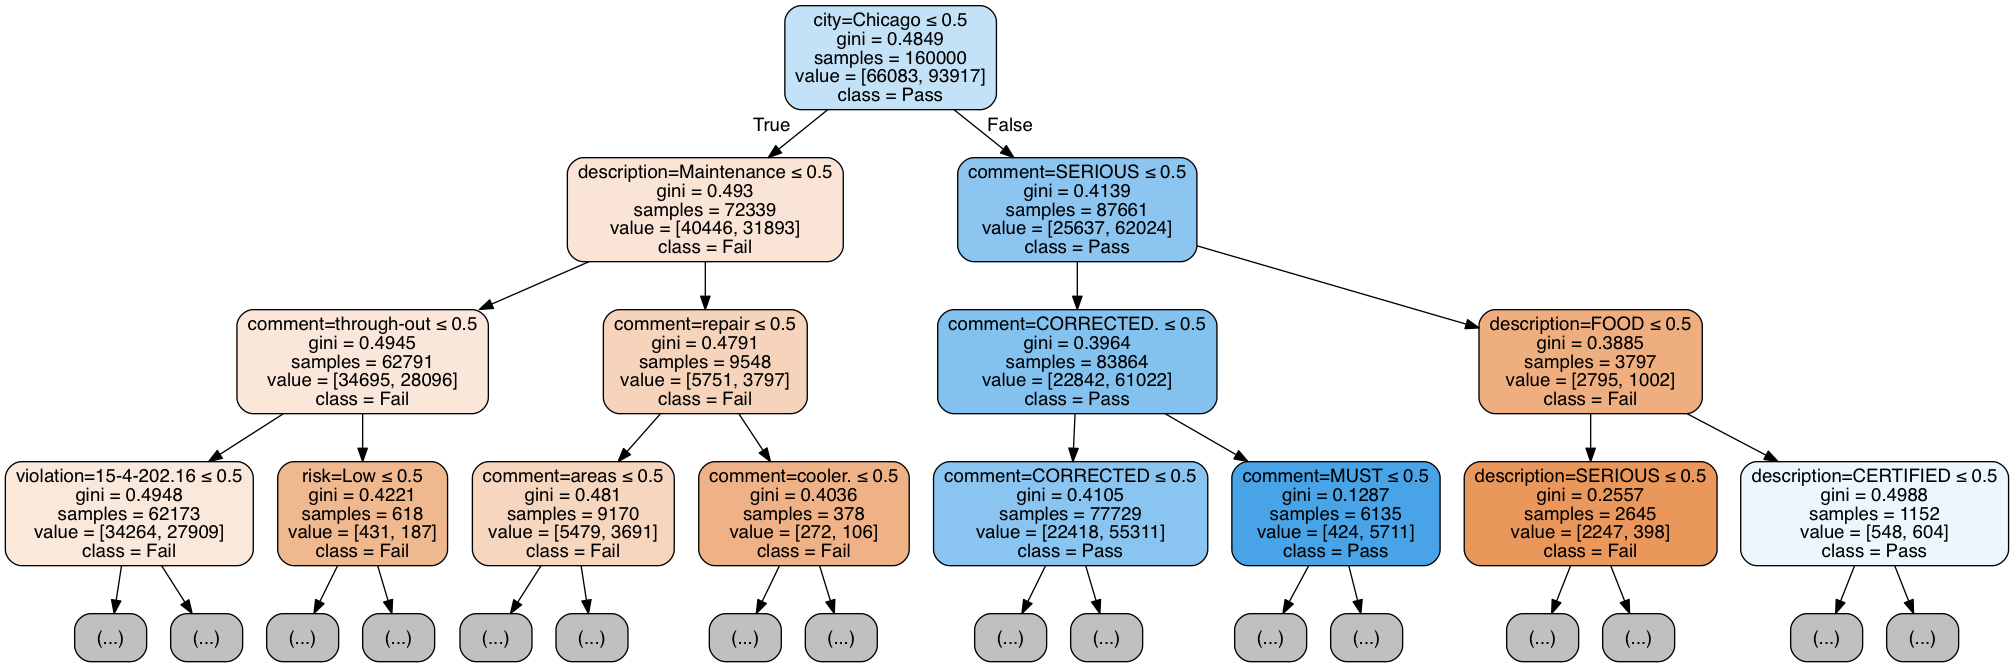

In [29]:
combined_feature_names = [x.replace('&', "and") for x in combined_vectorizer.feature_names_]
dot_data = tree.export_graphviz(combined_model, out_file=None, 
                        feature_names=combined_feature_names,
                        class_names=["Fail","Pass"],
                        max_depth=3,
                        filled=True, rounded=True,  
                        special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [30]:
combined_train_predicted = combined_model.predict(combined_fm_train)
print(metrics.classification_report(combined_target_train, combined_train_predicted))
print(metrics.confusion_matrix(combined_target_train, combined_train_predicted))

             precision    recall  f1-score   support

          0       0.91      1.00      0.95     66083
          1       1.00      0.93      0.96     93917

avg / total       0.96      0.96      0.96    160000

[[66024    59]
 [ 6513 87404]]


In [31]:
# generate model evaluation metrics
combined_test_predicted = combined_model.predict(combined_fm_test)
print(metrics.classification_report(combined_target_test, combined_test_predicted))
print(metrics.confusion_matrix(combined_target_test, combined_test_predicted))

             precision    recall  f1-score   support

          0       0.51      0.52      0.52     16498
          1       0.66      0.65      0.66     23502

avg / total       0.60      0.60      0.60     40000

[[ 8594  7904]
 [ 8134 15368]]


In [38]:
chicago_only_vec = DictVectorizer()
chicago_only_fm_train, chicago_only_fm_test, chicago_only_target_train, chicago_only_target_test, boston_only_fm, boston_only_result = prepare2(chicago_df, boston_df, chicago_only_vec, sample_size=100000)

In [39]:
chicago_only_fm_train.shape, chicago_only_fm_test.shape, boston_only_fm.shape

((79999, 115912), (20000, 115912), (100000, 115385))

In [40]:
chicago_only_model = DecisionTreeClassifier()

# generate decision tree from chicago training dataset
%time chicago_only_model.fit(chicago_only_fm_train, chicago_only_target_train)

CPU times: user 1min 58s, sys: 459 ms, total: 1min 58s
Wall time: 1min 59s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [41]:
chicago_only_train_predicted = chicago_only_model.predict(chicago_only_fm_train)
print(metrics.classification_report(chicago_only_target_train, chicago_only_train_predicted))
print(metrics.confusion_matrix(chicago_only_target_train, chicago_only_train_predicted))

             precision    recall  f1-score   support

          0       0.97      1.00      0.99     23294
          1       1.00      0.99      0.99     56705

avg / total       0.99      0.99      0.99     79999

[[23285     9]
 [  625 56080]]


In [42]:
chicago_only_test_predicted = chicago_only_model.predict(chicago_only_fm_test)
print(metrics.classification_report(chicago_only_target_test, chicago_only_test_predicted))
print(metrics.confusion_matrix(chicago_only_target_test, chicago_only_test_predicted))

             precision    recall  f1-score   support

          0       0.53      0.45      0.48      5867
          1       0.78      0.84      0.81     14133

avg / total       0.71      0.72      0.71     20000

[[ 2612  3255]
 [ 2312 11821]]


In [43]:
chicago_only_with_boston_predicted = chicago_only_model.predict(boston_only_fm)
print(metrics.classification_report(boston_only_result, chicago_only_with_boston_predicted))
print(metrics.confusion_matrix(boston_only_result, chicago_only_with_boston_predicted))

             precision    recall  f1-score   support

          0       0.30      0.14      0.19     29161
          1       0.71      0.86      0.78     70839

avg / total       0.59      0.65      0.61    100000

[[ 4010 25151]
 [ 9583 61256]]


In [44]:
boston_only_vec = DictVectorizer()
boston_only_fm_train, boston_only_fm_test, boston_only_target_train, boston_only_target_test, chicago_only_fm, chicago_only_result = prepare2(boston_df, chicago_df, boston_only_vec, sample_size=100000)

In [45]:
boston_only_fm_train.shape, boston_only_fm_test.shape, chicago_only_fm.shape

((79999, 115282), (20000, 115282), (100000, 115282))

In [46]:
boston_only_model = DecisionTreeClassifier()

# generate decision tree from chicago training dataset
%time boston_only_model.fit(boston_only_fm_train, boston_only_target_train)

CPU times: user 2min, sys: 481 ms, total: 2min 1s
Wall time: 2min 2s


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [47]:
# evaluate boston-only model with boston training data (should be good results)
boston_only_train_predicted = boston_only_model.predict(boston_only_fm_train)
print(metrics.classification_report(boston_only_target_train, boston_only_train_predicted))
print(metrics.confusion_matrix(boston_only_target_train, boston_only_train_predicted))

             precision    recall  f1-score   support

          0       0.86      1.00      0.93     44588
          1       1.00      0.80      0.89     35411

avg / total       0.92      0.91      0.91     79999

[[44548    40]
 [ 7029 28382]]


In [48]:
# evaluate boston-only model with boston test split (ideally good results)
boston_only_test_predicted = boston_only_model.predict(boston_only_fm_test)
print(metrics.classification_report(boston_only_target_test, boston_only_test_predicted))
print(metrics.confusion_matrix(boston_only_target_test, boston_only_test_predicted))

             precision    recall  f1-score   support

          0       0.50      0.56      0.53     11038
          1       0.36      0.31      0.33      8962

avg / total       0.44      0.44      0.44     20000

[[6143 4895]
 [6214 2748]]


In [49]:
# evaluate boston-only model with chicago data (can boston model be used to predict chicago results?)
boston_only_with_chicago_predicted = boston_only_model.predict(chicago_only_fm)
print(metrics.classification_report(chicago_only_result, boston_only_with_chicago_predicted))
print(metrics.confusion_matrix(chicago_only_result, boston_only_with_chicago_predicted))

             precision    recall  f1-score   support

          0       0.56      0.41      0.48     55626
          1       0.44      0.59      0.51     44374

avg / total       0.51      0.49      0.49    100000

[[23068 32558]
 [18325 26049]]
